In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import classification_report

# Desafio P&D 2

## 1) Pré processamento dos dados

Os dados a serem processados se encontram na pasta 'dados' e possuem formato .tsv (Tab Separated Values).

In [2]:
df_train = pd.read_csv('dados/train.tsv', delimiter='\t')
df_test = pd.read_csv('dados/test.tsv', delimiter='\t')

In [134]:
df_train.head(10)

,Id,IdSentenca,Texto,Sentimento
0,1,1,a series of escapades demonstrating the adage ...,1
1,2,1,a series of escapades demonstrating the adage ...,2
2,3,1,a series,2
3,4,1,a,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [4]:
sentence_train = df_train['IdSentenca'].unique()
sentence_test = df_test['IdSentenca'].unique()

Com auxílio do módulo <i>re</i> (Regular expressions) foi possível pré processar os dados textuais do <i>DataFrame</i>. Todos os sinais de pontuação foram removidos e as letras em maiúsculo foram substituídas pelo minúsculo.

In [7]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_text(text):
    text = [REPLACE_NO_SPACE.sub("", line.lower()) for line in text]
    text = [REPLACE_WITH_SPACE.sub(" ", line) for line in text]

    return text

In [8]:
df_train.Texto = preprocess_text(df_train.Texto)
df_test.Texto = preprocess_text(df_test.Texto)

Nota-se pelo cabeçalho do DataFrame que as alterações foram realizadas com sucesso.

In [98]:
df_train.head(10)

,Id,IdSentenca,Texto,Sentimento
0,1,1,a series of escapades demonstrating the adage ...,1
1,2,1,a series of escapades demonstrating the adage ...,2
2,3,1,a series,2
3,4,1,a,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


## 2) Extração de atributos

In [93]:
cv = CountVectorizer(binary=True)
cv.fit(df_train.Texto)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [125]:
X = cv.transform(df_train.Texto)
y = df_train.Sentimento.values
y = y.astype('int')

## 3) Análise dos dados

Text(0.5, 1.0, 'Quantidade de dados por classe')

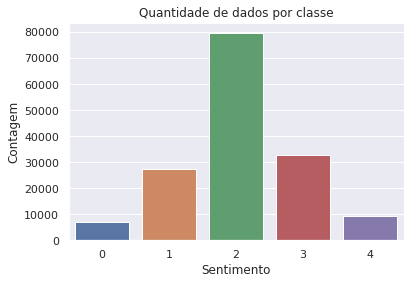

In [131]:
sns.countplot(y)
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.title('Quantidade de dados por classe')

O gráfico acima indica um alto desbalanceamento para as classes extremas. Isso ocorre em partes porque foram extraídos trechos de cada <i>review</i>, de modo que mais objetos da classe <i>neutro</i> fossem criados. Desta forma, os dados das classes "centrais" serão classificadas com maior facilidade, visto que qualquer frase desconexa será encaixada em uma delas.

In [132]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [133]:
X_test = cv.transform(df_test.Texto)

## 4) Classificação

Serão utilizados 3 classificadores: regressão logística, <i>random subspace</i> e #. Em cada um dos classificadores, foi realizado um <i>gridsearch</i> em um parâmetro específico de modo que se obtenha a melhor configuração testada em um conjunto de validação.<br><br>
Como verificado acima, a base de dados é desbalanceada nas classes extremas (<i>negativo</i> e <i>positivo</i>). Por este motivo, serão utilizadas duas métricas para avaliar os modelos construídos levando em conta o desbalanceamento. São elas: acurácia e <i>Geometric-mean</i>.

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Logistic Regression

O modelo de regressão logística, comparado a outros modelos, é mais fácil de ser interpretado e de aprendizagem mais rápida. Além de que modelos lineares tendem a performar bem em bases de dados dispersas. O parâmetro <i>C</i> explorado representa um coeficiente de regularização, utilizado para reduzir os efeitos de <i>overfitting</i> durante a aprendizagem.

In [112]:
for c in [0.05, 0.25, 0.5, 1, 1.25]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    print ("C = %s - Accuracy: %.3f/ G-mean: %.3f" % (c, accuracy_score(y_val, y_pred), geometric_mean_score(y_val, y_pred)))

C = 0.05 - Accuracy: 0.582/ G-mean: 0.221
C = 0.25 - Accuracy: 0.619/ G-mean: 0.338
C = 0.5 - Accuracy: 0.631/ G-mean: 0.375
C = 1 - Accuracy: 0.638/ G-mean: 0.411
C = 1.25 - Accuracy: 0.639/ G-mean: 0.420


### Random subspace

Para problemas de classificação em que exista o problema de alta dimensionalidade (grande quantidade de atributos), uma técnica bastante utilizada é o <i>Random Subspace</i>. O método consiste em coletar subconjuntos de mesmo tamanho do conjunto original, porém, com o número de atributos reduzido e de forma aleatória. O parâmetro  <i>max_features</i> explorado indica a proporção de atributos do conjunto original que serão selecionados para formar o novo subconjunto.<br><br>
Logo, para cada subconjunto será treinado um classificador (árvore de decisão). No final do processo, será obtido um <i>ensemble</i> de 20 classificadores.

In [113]:
for max_ in [0.5, 0.6, 0.7]:
    bag = BaggingClassifier(n_estimators=20, max_features=max_, max_samples=1.0)
    bag.fit(X_train, y_train)
    y_pred = bag.predict(X_val)
    print ("Max_feature = %s - Accuracy: %.3f/ G-mean: %.3f" % (max_, accuracy_score(y_val, y_pred), geometric_mean_score(y_val, y_pred)))

KeyboardInterrupt: 

### K-Nearest Neighbors

In [115]:
neighbors = [7, 9, 11, 13, 15]
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    print ("K = %s - Accuracy: %.3f/ G-mean: %.3f" % (k, accuracy_score(y_val, y_pred), geometric_mean_score(y_val, y_pred)))

K = 7 - Accuracy: 0.601/ G-mean: 0.326
K = 9 - Accuracy: 0.587/ G-mean: 0.275
K = 11 - Accuracy: 0.574/ G-mean: 0.232
K = 13 - Accuracy: 0.564/ G-mean: 0.198
K = 15 - Accuracy: 0.555/ G-mean: 0.166


In [140]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.06      0.01      0.02      1432
           1       0.18      0.04      0.06      5411
           2       0.51      0.90      0.65     15920
           3       0.21      0.05      0.08      6556
           4       0.07      0.01      0.02      1893

   micro avg       0.48      0.48      0.48     31212
   macro avg       0.21      0.20      0.16     31212
weighted avg       0.34      0.48      0.36     31212

